In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Any, Dict, Optional, Callable
import torch.distributions as td
import numpy as np
import gym

from growing_nn.graph.directed_graph import DirectedGraph
from growing_nn.graph.graph_nca import GraphNCA
from growing_nn.graph.generated_network import GeneratedNetwork
from ezrl.optimizer import RLOptimizer
from ezrl.policy import GymPolicy
from ezrl.algorithms.reinforce import ReinforceOptimizer

from ezrl.optimizer import RLOptimizer
from ezrl.policy import GymPolicy
from ezrl.algorithms.reinforce import ReinforceOptimizer

/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LunarLanderNCAPolicy(GymPolicy):
    def __init__(self, nca, num_growth_steps: int = 3):
        super().__init__()
        self.input_dims = 8
        self.output_dims = 4
        self.num_growth_steps = num_growth_steps

        self.nca = nca

    def generate_network(self, num_steps):
        graph = self.nca.grow(self.nca.graph, num_steps)
        generated_network = graph.generate_network()
        return generated_network

    def forward(self, obs: Any, generated_network = None) -> Dict[str, Any]:
        if generated_network is None:
            generated_network = self.generate_network(self.num_growth_steps)
        logits, _ = generated_network.batch_forward(inputs=obs)
        dist = td.Categorical(logits=logits)
        action = dist.sample()
        return {"action":action, "dist":dist}

    def act(self, obs: Any, generated_network = None):
        out = self.forward(obs, generated_network)
        return out["action"].item(), out

In [3]:
def reinforce_rollout(
    policy: GymPolicy, env_name: str = None, env=None, env_creation_fn=None
):
    if env_name is None and env is None:
        raise ValueError("env_name or env must be provided!")
    if env is None:
        if env_creation_fn is None:
            env_creation_fn = gym.make
        env = env_creation_fn(env_name)
    done = False
    observations, actions, rewards = (
        [],
        [],
        [],
    )
    observation = env.reset()
    with torch.no_grad():
        generated_network = policy.generate_network(policy.num_growth_steps)
        while not done:
            action, out = policy.act(
                torch.from_numpy(observation).unsqueeze(0).to(policy.device), generated_network
            )
            next_observation, reward, done, info = env.step(action)

            observations.append(observation)
            actions.append(action)
            rewards.append(reward)

            observation = next_observation

    return np.array(observations), np.array(actions), np.array(rewards)


In [4]:
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime

def get_tensorboard_logger(experiment_name: str, base_log_path: str = "tensorboard_logs"):
    log_path = "{}/{}_{}".format(
            base_log_path, experiment_name, datetime.now()
        )
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: tensorboard --logdir '{}'".format(
            full_log_path
        )
    )
    return train_writer

/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/tensorboard/compat/proto/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/tensorboard/compat/proto/tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescri

In [5]:
def make_inital_graph(num_inputs, num_outputs, num_channels, device):
    x = torch.ones((num_inputs + num_outputs, num_channels), device=device)
    edge_dict = {}
    for i in range(num_inputs):
        edge_dict[i] = list(range(num_inputs, num_inputs+num_outputs))
    for i in range(num_inputs, num_inputs+num_outputs):
        edge_dict[i] = []
    return DirectedGraph(x, edge_dict, num_inputs, num_outputs)

## Training

In [6]:
NUM_OPERATIONS = 3
NUM_ACTIVATIONS = 2
NUM_HIDDEN_CHANNELS = 24
NUM_CHANNELS = GraphNCA.get_number_of_channels(NUM_OPERATIONS, NUM_ACTIVATIONS, NUM_HIDDEN_CHANNELS)

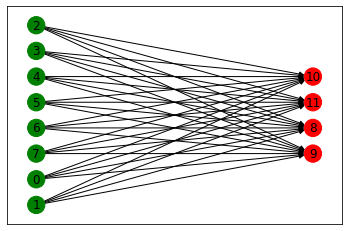

In [7]:
device = torch.device('cuda')

graph = make_inital_graph(8, 4, NUM_CHANNELS, device)
image = graph.plot()

In [8]:
nca = GraphNCA(graph, NUM_HIDDEN_CHANNELS, max_replications=1)

policy = LunarLanderNCAPolicy(nca,num_growth_steps=32)
policy = policy.to(device)

In [ ]:
from tqdm import tqdm

bar = tqdm(np.arange(50000))

writer = get_tensorboard_logger("ReinforceNCALunarLander")
optimizer = ReinforceOptimizer(policy, lr=0.01)

for i in bar:
    observations, actions, rewards = optimizer.rollout(reinforce_rollout, env_name = "LunarLander-v2")

    torch_observations = torch.from_numpy(observations).to(policy.device)
    torch_actions = torch.from_numpy(actions).float().to(policy.device)
    torch_rewards = torch.from_numpy(rewards).float().to(policy.device)


    optimizer.zero_grad()
    loss = optimizer.loss_fn(torch_observations, torch_actions, torch_rewards)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.0)
    optimizer.step()

    # metrics

    grad_dict = {}
    for n, W in policy.named_parameters():
        if W.grad is not None:
            grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

    loss = loss.item()
    sum_reward = np.sum(rewards)

    metrics_dict = {"loss":loss, "sum_reward":sum_reward, **grad_dict}

    for key in metrics_dict:
        writer.add_scalar(key, metrics_dict[key], i)


    bar.set_description("Loss: {}, Reward: {}".format(loss, sum_reward))

  0%|                                                                         | 0/50000 [00:00<?, ?it/s]/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Follow tensorboard logs with: tensorboard --logdir '/home/shyam/Code/growing-nn/notebooks/tensorboard_logs/ReinforceNCALunarLander_2022-08-14 18:17:23.876973'


Loss: 334.1636962890625, Reward: -40.534195253267946:   0%|      | 12/50000 [01:48<120:37:11,  8.69s/it]